# Text summarization (Extractive)

An usupervised model to summarize the text article. The method uses LSA (Latent semantic analysis to find the best semantic sentences in the article.

This notebook implements a TextAnalyzer class which take a text document and displyas three analysis on it.

* Word cloud of Noun
* Bar graph of frequent words
* Bar graph of frequent nouns
* Summary of article ( Implemented using LSA technique )


In [1]:
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
from itertools import cycle
import numpy as np
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import MeanShift, estimate_bandwidth,KMeans
from wordcloud import WordCloud, ImageColorGenerator
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('popular')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer,sent_tokenize
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
#from gensim.summarization import summarize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\Asus\AppData\Roaming\nltk_data.

In [8]:
path = "/Users/Asus/Documents/AI_text/example.txt"
STOPWORDS = set(stopwords.words('english'))
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
punctuations = set(string.punctuation)
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'\w+')

## Utility functions

In [9]:
def read_text(path):
    file = open(path,'r+')
    corpus = file.read()
    return corpus

In [10]:
def clean_text(text):
    text = text.lower()
    #sentwords = word_tokenize(text)
    sentwords = tokenizer.tokenize(text)
    words = [sentword for sentword in sentwords if sentword not in punctuations ]
    words = [stemmer.stem(word) for word in words]
    words = [word for word in words if len(word) >= 2]
    text = ' '.join([word for word in words if word not in stopwords.words('english')])
    #print(text)
    return text

In [11]:
### Get the frequency of each of words #####
def word_frequency(text):
    corpus = sent_tokenize(text)
    
    words = []
    sentences = [clean_text(i) for i in corpus]
    for sent in sentences:
        word = sent.split(' ')
        words += word
        
    return dict(Counter(words))   

In [12]:
def term_document_matrix(corpus):
    vec = TfidfVectorizer(input = corpus, ngram_range=(1, 2))
    matrix = vec.fit_transform(corpus)
    return matrix   

In [13]:
class TextAnalyzer(object):
    def __init__(self,text=None):
        self.text = text
        
        
    def Visualize_word_cloud(self):
        text = self.text
        text = word_tokenize(text)
        tags = nltk.pos_tag(text)
        
        nouns = [i for i,j in tags if j=='NN']
        nouns_freq = dict(Counter(nouns))
        
        wordcloud = WordCloud().generate_from_frequencies(nouns_freq)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")

        # lower max_font_size
        wordcloud = WordCloud(max_font_size=35).generate_from_frequencies(nouns_freq)
        plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()
        
    def Visualize_top_frequent_word_count(self,top_n_percent):
        text = self.text
        word_freq = word_frequency(text)
        top_1_percent = int(len(word_freq)*(top_n_percent/100.0))
        top_words = sorted(word_freq.items(),key=lambda x: x[1],reverse=True)[:top_1_percent]
        frequent_word = [i[0] for i in top_words]
        frequency = [i[1] for i in top_words]

        fig, ax = plt.subplots(figsize=(7,5))
        sns.barplot(frequency,frequent_word,ax = ax)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.title('Most frequent words')
        plt.show()
        
        
    def Visualize_top_frequent_nouns(self,top_n_percent):
        text = self.text
        tokens = nltk.word_tokenize(text.lower())
        text = nltk.Text(tokens)
        tags = nltk.pos_tag(text)

        tags = nltk.pos_tag(text)
        nouns = [i for i,j in tags if j=='NN']
        nouns_freq = dict(Counter(nouns))
        slice = int(len(nouns)*(top_n_percent/100.0))
        freq_nouns = sorted(nouns_freq.items(),key=lambda x: x[1], reverse=True)[:slice]
        top_noun_words = [i[0] for i in freq_nouns]
        top_noun_frequency = [i[1] for i in freq_nouns]

        fig, ax = plt.subplots(figsize=(7,5))
        sns.barplot( top_noun_frequency,top_noun_words,ax = ax)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.title('Most frequent nouns in the corpus')
        plt.show()

    def Visualize_corpus(self):
        text = self.text
        corpus = sent_tokenize(text)
        decomposer = TruncatedSVD(n_components=3,random_state=0)
        tdm = term_document_matrix(corpus)
        reduced = decomposer.fit_transform(tdm)
        x,y,z = reduced.T

        fig = plt.figure(figsize=(9,7))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x,y,z,edgecolor='k')
        ax.set_title('Document Visualization ')
        plt.title('Document Visualiszation')
        plt.show()

            

        
    def summarize(self,max_words):
        text = self.text
        corpus = sent_tokenize(text)
        
        tdm = term_document_matrix(corpus)
        u, sigma, v_t = np.linalg.svd(tdm.toarray().T, full_matrices = True)
        max_cols = v_t.argmax(axis = 1)
        included = set()
        summarised_sent = []
        summary = []
        
        already_included = set()
        totalWords = 0
        selected = []

        for i in max_cols:
            
            if i not in already_included:
                already_included.add(i)
                selected.append((i, corpus[i])) # stash the index of the sentence as well
                totalWords += len(corpus[i].split(' '))
                if totalWords > max_words:
                    break
    
        
        return [s[1] for s in sorted(selected, key=lambda x: x[0])]
    
    

In [14]:
text = read_text(path)

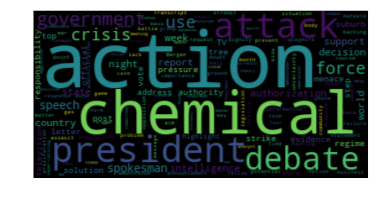

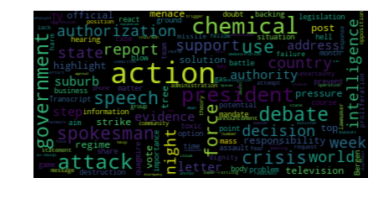

In [15]:
Anly = TextAnalyzer(text)
Anly.Visualize_word_cloud()

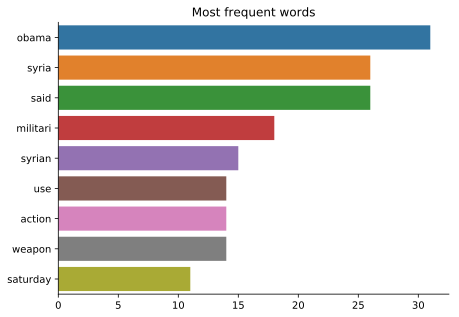

In [17]:
Anly.Visualize_top_frequent_word_count(2)

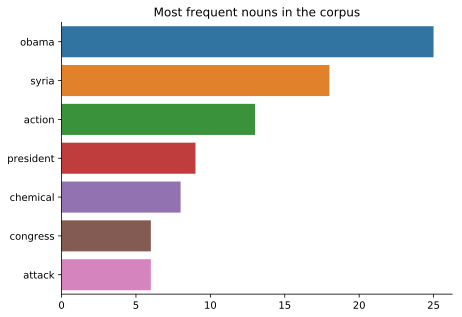

In [18]:
Anly.Visualize_top_frequent_nouns(2)

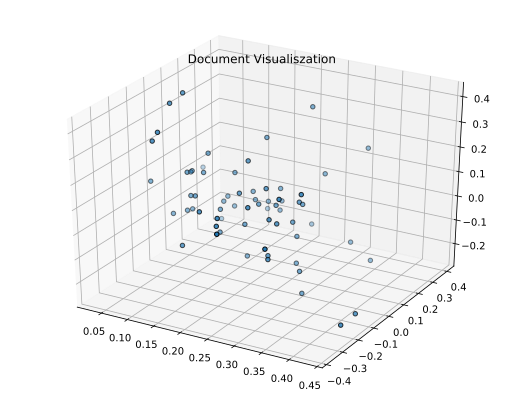

In [19]:
Anly.Visualize_corpus()

In [21]:
Anly.summarize(max_words=150)

["Top U.S. officials have said there's no doubt that the Syrian government was behind it, while Syrian officials have denied responsibility and blamed jihadists fighting with the rebels.",
 'Syria\'s alleged use of chemical weapons earlier this month "is an assault on human dignity," the president said.',
 'In a world with many dangers, this menace must be confronted."',
 '"So we are quite concerned."',
 '"We are glad the president is seeking authorization for any military action in Syria in response to serious, substantive questions being raised."',
 'An anchor on Syrian state television said Obama "appeared to be preparing for an aggression on Syria based on repeated lies."',
 'Both Obama and Cameron, he said, "climbed to the top of the tree and don\'t know how to get down."',
 'The Syrian government has denied that it used chemical weapons in the August 21 attack, saying that jihadists fighting with the rebels used them in an effort to turn global sentiments against it.']